In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32
CHANNELS = 3
INPUT_SHAPE = (BATCH_SIZE,) + IMAGE_SIZE + (CHANNELS,)

import os
MODELS_DIR = "/content/drive/MyDrive/amogus/models"
os.makedirs(MODELS_DIR, exist_ok=True)

In [3]:
import tensorflow as tf

print("tf.__version__: {}".format(tf.__version__))

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = "/content/drive/MyDrive/amogus/images",
    shuffle = True,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE
)

tf.__version__: 2.8.2
Found 2740 files belonging to 2 classes.


In [4]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, 
                              shuffle=True, shuffle_size=10000):
  
    ## train-test-validation split function
      
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=42)
        
    ds_size = len(ds)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [5]:
## split dataset into training, validation, and testing datasets

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

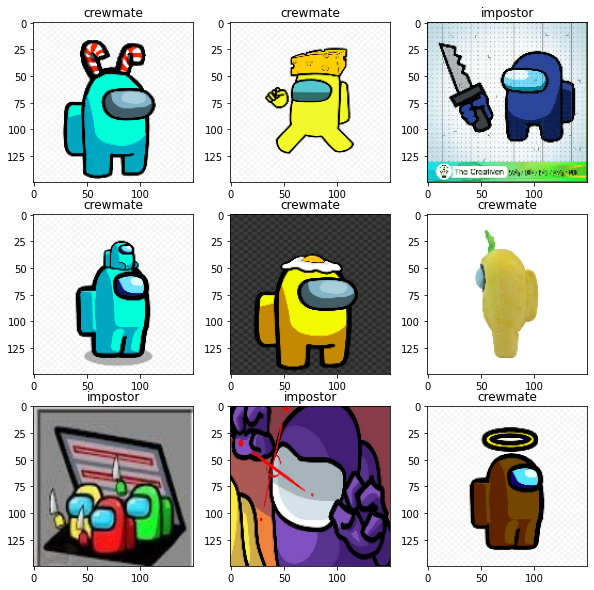

In [6]:
## visualize few images from training dataset

import matplotlib.pyplot as plt

class_names = dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        # plt.axis("off")

In [7]:
## optimize dataset for training performance

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
## data preprocessing pipepline

data_preprocessing = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(*IMAGE_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

## data augmentation pipeline

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

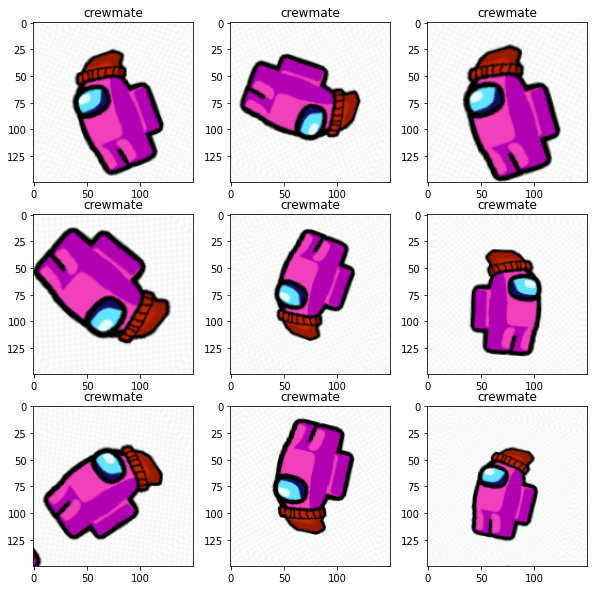

In [21]:
## visualize augmented images

import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(class_names[int(labels[0])])
        # plt.axis("off")

In [22]:
base_model = tf.keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=IMAGE_SIZE + (CHANNELS,),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=IMAGE_SIZE + (CHANNELS,))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")                                 
])(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_9 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0      

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.BinaryAccuracy(), 
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(MODELS_DIR, "xception_v1.h5"), 
    save_best_only=True)

epochs = 150
model.fit(train_ds, epochs=epochs, validation_data=val_ds, 
          callbacks=[checkpoint_cb])

Epoch 1/150
68/68 [==============================] - 37s 319ms/step - loss: 0.5385 - binary_accuracy: 0.7348 - precision: 0.6579 - recall: 0.5940 - val_loss: 0.3542 - val_binary_accuracy: 0.8484 - val_precision: 0.7938 - val_recall: 0.8191
Epoch 2/150
68/68 [==============================] - 5s 67ms/step - loss: 0.4422 - binary_accuracy: 0.8073 - precision: 0.7412 - recall: 0.7385 - val_loss: 0.3557 - val_binary_accuracy: 0.8443 - val_precision: 0.7500 - val_recall: 0.8936
Epoch 3/150
68/68 [==============================] - 5s 78ms/step - loss: 0.4134 - binary_accuracy: 0.8249 - precision: 0.7573 - recall: 0.7771 - val_loss: 0.3328 - val_binary_accuracy: 0.8934 - val_precision: 0.8696 - val_recall: 0.8511
Epoch 4/150
68/68 [==============================] - 4s 65ms/step - loss: 0.4124 - binary_accuracy: 0.8299 - precision: 0.7649 - recall: 0.7821 - val_loss: 0.3546 - val_binary_accuracy: 0.8730 - val_precision: 0.8247 - val_recall: 0.8511
Epoch 5/150
68/68 [===========================

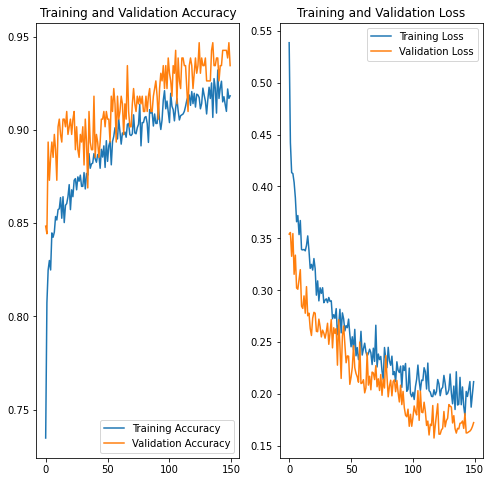

In [26]:
def plot_learning_curves(history, epochs):
  acc = history.history['binary_accuracy']
  val_acc = history.history['val_binary_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs_range = range(epochs)
  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')
  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

plot_learning_curves(model.history, epochs)

In [30]:
def get_y_true_pred(model, test_ds):

  y_true = list()
  y_pred = list()

  for x, y in test_ds:
    y_true.append(y)
    y_pred.append((model.predict(x) > 0.5).astype(np.uint32))
  
  y_true = tf.concat(y_true, axis=0)
  y_pred = tf.concat(y_pred, axis=0)

  return y_true, y_pred


# load model that performed  best in validation during training
model = tf.keras.models.load_model(os.path.join(MODELS_DIR, "xception_v1.h5"))
y_true, y_pred = get_y_true_pred(model, test_ds)

In [31]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93       210
           1       0.83      0.95      0.89       110

    accuracy                           0.92       320
   macro avg       0.90      0.92      0.91       320
weighted avg       0.92      0.92      0.92       320



In [32]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
     metrics=[tf.keras.metrics.BinaryAccuracy(), 
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()],
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(MODELS_DIR, "xception_v2.h5"), 
    save_best_only=True)

epochs = 100
model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[checkpoint_cb])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_9 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [34]:
model = tf.keras.models.load_model(os.path.join(MODELS_DIR, "xception_v2.h5"))
model.evaluate(test_ds)

10/10 [==============================] - 2s 64ms/step - loss: 0.1804 - binary_accuracy: 0.9219 - precision_1: 0.8455 - recall_1: 0.9455


[0.18043287098407745, 0.921875, 0.8455284833908081, 0.9454545378684998]

In [35]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),  # increase learning rate
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
     metrics=[tf.keras.metrics.BinaryAccuracy(), 
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()],
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(MODELS_DIR, "xception_v3.h5"), 
    save_best_only=True)

epochs = 50
model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[checkpoint_cb])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_9 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [36]:
model = tf.keras.models.load_model(os.path.join(MODELS_DIR, "xception_v3.h5"))
model.evaluate(test_ds)

10/10 [==============================] - 2s 63ms/step - loss: 0.1834 - binary_accuracy: 0.9156 - precision_2: 0.8374 - recall_2: 0.9364


[0.18344900012016296, 0.9156249761581421, 0.8373983502388, 0.9363636374473572]

In [44]:
base_model = tf.keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=IMAGE_SIZE + (CHANNELS,),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=IMAGE_SIZE + (CHANNELS,))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.models.Sequential([
                                      
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation="relu"),
     tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")                                 
])(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_9 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_7 (Dropout)         (None, 2048)              0         
                                                           

In [45]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.BinaryAccuracy(), 
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(MODELS_DIR, "xception_v4.h5"), 
    save_best_only=True)

epochs = 150
model.fit(train_ds, epochs=epochs, validation_data=val_ds, 
          callbacks=[checkpoint_cb])

Epoch 1/150
68/68 [==============================] - 41s 88ms/step - loss: 0.5705 - binary_accuracy: 0.7015 - precision_7: 0.6342 - recall_7: 0.4620 - val_loss: 0.3606 - val_binary_accuracy: 0.8361 - val_precision_7: 0.7755 - val_recall_7: 0.8085
Epoch 2/150
68/68 [==============================] - 5s 66ms/step - loss: 0.4566 - binary_accuracy: 0.7967 - precision_7: 0.7238 - recall_7: 0.7310 - val_loss: 0.3846 - val_binary_accuracy: 0.8484 - val_precision_7: 0.7568 - val_recall_7: 0.8936
Epoch 3/150
68/68 [==============================] - 4s 66ms/step - loss: 0.4335 - binary_accuracy: 0.8207 - precision_7: 0.7416 - recall_7: 0.7933 - val_loss: 0.3652 - val_binary_accuracy: 0.8811 - val_precision_7: 0.8351 - val_recall_7: 0.8617
Epoch 4/150
68/68 [==============================] - 5s 67ms/step - loss: 0.4270 - binary_accuracy: 0.8290 - precision_7: 0.7550 - recall_7: 0.7983 - val_loss: 0.3644 - val_binary_accuracy: 0.8770 - val_precision_7: 0.8077 - val_recall_7: 0.8936
Epoch 5/150
68/

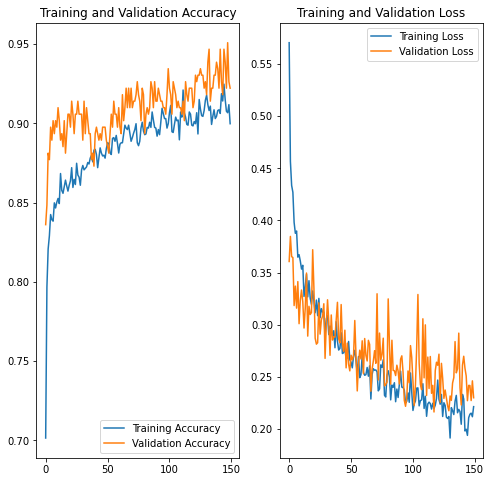

In [46]:
plot_learning_curves(model.history, epochs)

In [47]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
     metrics=[tf.keras.metrics.BinaryAccuracy(), 
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()],
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(MODELS_DIR, "xception_v4.h5"), 
    save_best_only=True)

epochs = 150
model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[checkpoint_cb])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_9 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_7 (Dropout)         (None, 2048)              0         
                                                           

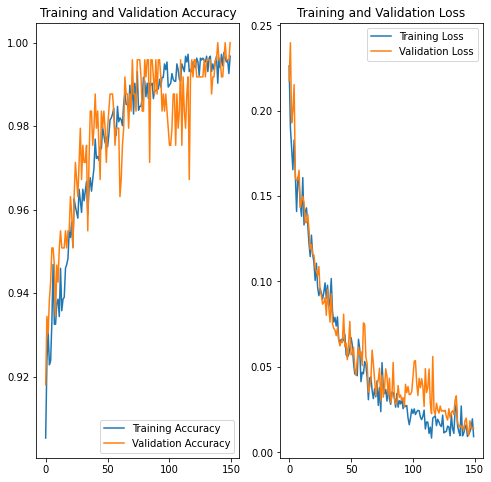

In [48]:
plot_learning_curves(model.history, epochs)

In [49]:
# load model that performed  best in validation during training
modelv4 = tf.keras.models.load_model(os.path.join(MODELS_DIR, "xception_v4.h5"))
y_true, y_pred = get_y_true_pred(modelv4, test_ds)

In [52]:
_ = modelv4.evaluate(test_ds)

10/10 [==============================] - 1s 68ms/step - loss: 0.1129 - binary_accuracy: 0.9688 - precision_8: 0.9386 - recall_8: 0.9727


In [50]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       210
           1       0.94      0.97      0.96       110

    accuracy                           0.97       320
   macro avg       0.96      0.97      0.97       320
weighted avg       0.97      0.97      0.97       320



In [71]:
def predict(model, img, threshold=0.5):

  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # create a bactch

  raw_prediction = model.predict(img_array)[0][0]
  prediction = 1 if raw_prediction > threshold else 0
  class_name = class_names[prediction]
  confidence = (1 - raw_prediction) * 100 if prediction == 0 else (raw_prediction * 100)

  return class_name, round(confidence, 2)

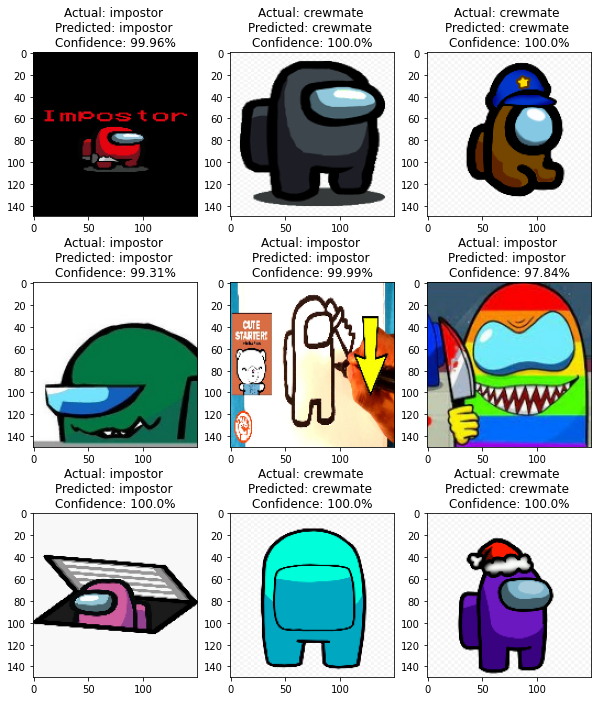

In [82]:
plt.figure(figsize=(10, 12))

for images, labels in test_ds.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      class_name, confidence  = predict(modelv4, images[i].numpy())
      actual_class = class_names[labels[i]]
      plt.title(f"Actual: {actual_class} \nPredicted: {class_name} \nConfidence: {confidence}%")